## **Name : Manya J Trivedi**

# **AIML Sem 7**

## **Unit 2 CNN practical**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d muratkokludataset/grapevine-leaves-image-dataset

 98% 107M/109M [00:06<00:00, 22.9MB/s]
100% 109M/109M [00:06<00:00, 18.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("grapevine-leaves-image-dataset.zip", 'r')
zip_ref.extractall('grapevine-leaves-image-dataset')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, UpSampling2D, Input, LeakyReLU
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D, BatchNormalization
from keras.utils import Sequence
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from sklearn.neural_network import MLPClassifier
from keras.utils.vis_utils import plot_model
from keras.layers.core import Dense, Activation, Dropout
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from keras import layers
import random as rnd
import cv2
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline


In [ ]:
main_df = pd.DataFrame()
main_path = '/content/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris =  main_path + 'Ala_Idris'
path_Buzgulu =  main_path +'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+ '/' + class_ + '/' + image)

main_df['classes'] = classes
main_df['path'] = paths
print(len(main_df))
main_df.head()

500


,images,classes,path
0,Ak (62).png,Ak,/content/grapevine-leaves-image-dataset/Grapev...
1,Ak (31).png,Ak,/content/grapevine-leaves-image-dataset/Grapev...
2,Ak (43).png,Ak,/content/grapevine-leaves-image-dataset/Grapev...
3,Ak (53).png,Ak,/content/grapevine-leaves-image-dataset/Grapev...
4,Ak (51).png,Ak,/content/grapevine-leaves-image-dataset/Grapev...


In [ ]:
main_path = '/content/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
Ak_route = main_path + 'Ak'
Ala_Idris_route = main_path + 'Ala_Idris'
Buzgulu_route = main_path +'Buzgulu'
Dimnit_route =  main_path + 'Dimnit'
Nazli_route =  main_path + 'Nazli'
count_bar = {}
count_bar['labels'] = labels
count_bar['count'] = [len(os.listdir(main_path+i)) for i in labels]
count_bar_df = pd.DataFrame(count_bar, index=[1,2,3,4,5])

root_dir = "/content/grapevine-leaves-image-dataset"
#import shutil
#shutil.rmtree('./grape_dataset')
#/content/grapevine-leaves-image-dataset/training


path = os.path.join(root_dir, "training")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))

path = os.path.join(root_dir, "validating")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))

path = os.path.join(root_dir, "testing")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))


def train_test_split(SOURCE, TRAINING, TESTING, VALIDATING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + ' is zero length, so ignoring.')

        import random
        from shutil import copyfile

        training_length = int((len(files) * SPLIT_SIZE)*SPLIT_SIZE)
        validating_length = int((len(files) * SPLIT_SIZE)) - training_length
        testing_length = int(len(files) * (1- SPLIT_SIZE))
        shuffled_set = random.sample(files, len(files))
        training_set = shuffled_set[0:training_length]
        validating_set = shuffled_set[training_length+1:-testing_length]
        testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        src_file = SOURCE + filename
        dest_file = TRAINING + filename
        copyfile(src_file, dest_file)

    for filename in validating_set:
        src_file = SOURCE + filename
        dest_file = VALIDATING + filename
        copyfile(src_file, dest_file)

    for filename in testing_set:
        src_file = SOURCE + filename
        dest_file = TESTING + filename
        copyfile(src_file, dest_file)


training_dir = "/content/grapevine-leaves-image-dataset/training"
testing_dir = "/content/grapevine-leaves-image-dataset/testing"
validating_dir = "/content/grapevine-leaves-image-dataset/validating"
split_size = 0.8


from keras.applications.resnet import preprocess_input
for i in range(10):

    for i in labels:
        label_source_dir = "/content/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/" + str(i) + "/"
        training_label_dir = os.path.join(training_dir, (str(i)+"/"))
        validating_label_dir = os.path.join(validating_dir, (str(i)+"/"))
        testing_label_dir = os.path.join(testing_dir, (str(i)+"/"))
        train_test_split(label_source_dir, training_label_dir, testing_label_dir, validating_label_dir, split_size)

    resnet50_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.10,brightness_range=[0.6,1.4],channel_shift_range=0.7,width_shift_range=0.15,height_shift_range=0.15,shear_range=0.15,horizontal_flip=True,fill_mode='nearest',preprocessing_function=preprocess_input)
    train_generator_resnet50 = resnet50_datagen.flow_from_directory(training_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    val_generator_resnet50 = resnet50_datagen.flow_from_directory(validating_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    resnet50_datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator_resnet50 = resnet50_datagen_test.flow_from_directory(testing_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    resnet = tf.keras.applications.ResNet50(input_shape=(227,227,3), include_top=False, weights='imagenet', classes=5)

    x = GlobalAveragePooling2D()(resnet.output)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units=5,activation = 'softmax')(x)
    model_resnet = Model(resnet.input, output)



    opt = SGD(lr=0.001)
    model_resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    savebest = tf.keras.callbacks.ModelCheckpoint('resnet_beforefinetuning.h5', save_best_only=True);
    history_resnet = model_resnet.fit(train_generator_resnet50,
                                      validation_data=val_generator_resnet50,
                                      epochs=35,
                                     callbacks=[savebest])

    model_resnet.evaluate(test_generator_resnet50)[1]

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 95 images belonging to 5 classes.
94765736/94765736 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/35
10/10 [==============================] - 28s 1s/step - loss: 1.7395 - accuracy: 0.2500 - val_loss: 1.7054 - val_accuracy: 0.2625
Epoch 2/35
10/10 [==============================] - 9s 904ms/step - loss: 1.7010 - accuracy: 0.2562 - val_loss: 1.6723 - val_accuracy: 0.2750
Epoch 3/35
10/10 [==============================] - 13s 1s/step - loss: 1.6624 - accuracy: 0.2375 - val_loss: 1.6462 - val_accuracy: 0.2125
Epoch 4/35
10/10 [==============================] - 10s 1s/step - loss: 1.6217 - accuracy: 0.2781 - val_loss: 1.6161 - val_accuracy: 0.2500
Epoch 5/35
10/10 [==============================] - 11s 1s/step - loss: 1.5975 - accuracy: 0.2531 - val_loss: 1.5955 - val_accuracy: 0.2875
Epoch 6/35
10/10 [==============================] - 11s 1s/step - loss: 1.4953 - accuracy: 0.3562 - val_loss: 1.5509 - val_accuracy: 0.3500
Epoch 7/35
10/10 [==============================] - 10s 990ms/step - loss: 1.5032 - accuracy: 0.3531 - val_loss: 1.5052 - val_accuracy: 0.3250
Epoch 8/35
10/1

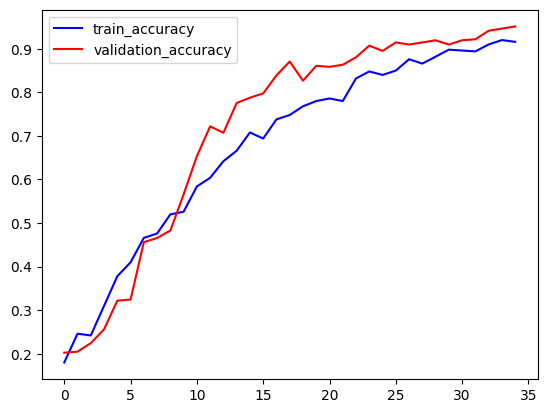

In [ ]:
plt.plot(history_resnet.history['accuracy'],color='blue',label='train_accuracy')
plt.plot(history_resnet.history['val_accuracy'],color='red',label='validation_accuracy')
plt.legend()
plt.show()

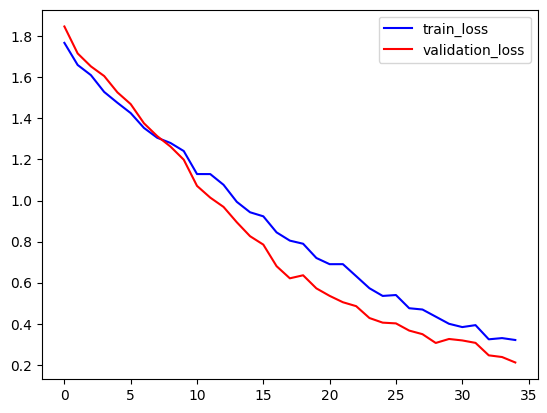

In [ ]:
plt.plot(history_resnet.history['loss'],color='blue',label='train_loss')
plt.plot(history_resnet.history['val_loss'],color='red',label='validation_loss')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
num_of_test_samples = 436
batch_size = 32
Y_pred_res = model_resnet.predict_generator(test_generator_resnet50, num_of_test_samples // batch_size+1)
y_pred_res = np.argmax(Y_pred_res, axis=1)
print('Confusion Matrix')
conf_matrix_res = confusion_matrix(test_generator_resnet50.classes, y_pred_res)
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)

<ipython-input-38-21c6c07f5300>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_res = model_resnet.predict_generator(test_generator_resnet50, num_of_test_samples // batch_size+1)


Confusion Matrix
[[11 18 15 20 21]
 [11 14 21 25 20]
 [10 16 20 25 15]
 [12 14 21 24 16]
 [15 14 19 25 14]]


In [39]:
test_generator_resnet50.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [40]:
y_pred_res

array([1, 4, 0, 3, 1, 2, 2, 2, 4, 1, 3, 1, 0, 0, 4, 1, 1, 2, 3, 2, 4, 2,
       3, 2, 3, 1, 1, 3, 4, 4, 4, 4, 1, 3, 1, 0, 3, 2, 1, 2, 4, 3, 2, 3,
       4, 3, 4, 2, 4, 0, 0, 3, 0, 1, 2, 4, 3, 3, 0, 3, 0, 2, 3, 1, 3, 3,
       4, 4, 4, 1, 4, 3, 2, 4, 3, 0, 2, 4, 1, 1, 4, 1, 4, 0, 1, 2, 3, 3,
       3, 3, 1, 3, 2, 0, 3, 2, 0, 2, 4, 1, 3, 1, 3, 2, 1, 1, 1, 2, 4, 3,
       4, 1, 0, 3, 3, 1, 4, 2, 3, 0, 2, 0, 3, 3, 4, 2, 1, 2, 2, 1, 2, 1,
       3, 4, 3, 3, 0, 0, 2, 0, 1, 4, 4, 1, 0, 2, 3, 3, 1, 4, 2, 0, 3, 3,
       4, 2, 4, 4, 2, 3, 4, 2, 0, 3, 3, 3, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4,
       2, 3, 3, 4, 1, 4, 1, 2, 3, 0, 1, 2, 2, 2, 3, 0, 4, 4, 4, 1, 4, 4,
       3, 0, 0, 3, 3, 1, 3, 2, 1, 3, 1, 2, 3, 1, 0, 3, 4, 1, 3, 4, 2, 0,
       3, 2, 4, 1, 4, 3, 1, 2, 4, 1, 2, 1, 3, 3, 0, 2, 2, 0, 1, 3, 4, 2,
       1, 1, 0, 0, 4, 2, 2, 3, 2, 3, 2, 3, 4, 2, 3, 3, 3, 2, 3, 3, 1, 0,
       2, 3, 3, 0, 1, 3, 2, 3, 4, 1, 3, 0, 0, 4, 3, 2, 1, 1, 4, 4, 3, 2,
       3, 4, 1, 2, 2, 2, 1, 4, 3, 2, 3, 4, 3, 3, 3,